In [1]:
import pandas as pd
from swarm_sim import *
from metrics import *
import random 
import nbimporter
from metrics import path_disparity, path_redundancy, routing_cost, flow_robustness, network_efficiency, critical_nodes
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### extraction Data 

In [2]:
df = pd.read_csv("Traces.csv", header=None)  

# Créer les noms de colonnes pour le temps
time_cols = [str(i+1) for i in range(10000)]
df.columns = time_cols

#générer les noms des lignes (cordonnées des satellites):
coord_names = []
for i in range(1, 101):  # 100 satellites
    coord_names.append(f"satx{i}")
    coord_names.append(f"saty{i}")
    coord_names.append(f"satz{i}")
df["coords"] = coord_names
df = df.set_index("coords")

dft = df.transpose()  # maintenant chaque ligne = un instant

### Visualisation pour un satellite 

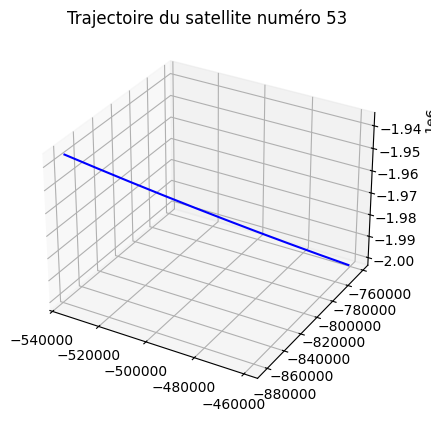

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

sat_id = 53
x, y, z = [], [], []

for t in range(10):  # ou juste 0 à 1000 pour un échantillon
    x.append(dft.loc[str(t+1)]['satx'+str(sat_id)])
    y.append(dft.loc[str(t+1)]['saty'+str(sat_id)])
    z.append(dft.loc[str(t+1)]['satz'+str(sat_id)])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, color='blue')
ax.set_title(f"Trajectoire du satellite numéro {sat_id}")
plt.show()


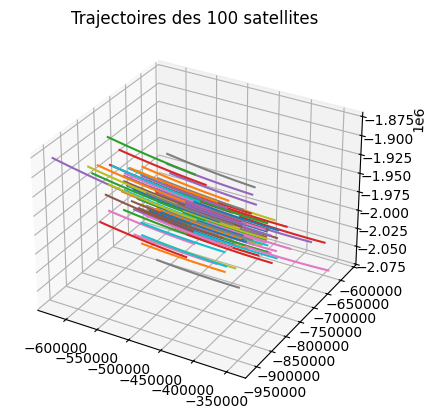

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for sat_id in range(1, 101):
    x, y, z = [], [], []
    for t in range(10):
        x.append(dft.loc[str(t+1)]['satx'+str(sat_id)])
        y.append(dft.loc[str(t+1)]['saty'+str(sat_id)])
        z.append(dft.loc[str(t+1)]['satz'+str(sat_id)])
    ax.plot(x, y, z)

ax.set_title("Trajectoires des 100 satellites")
plt.show()


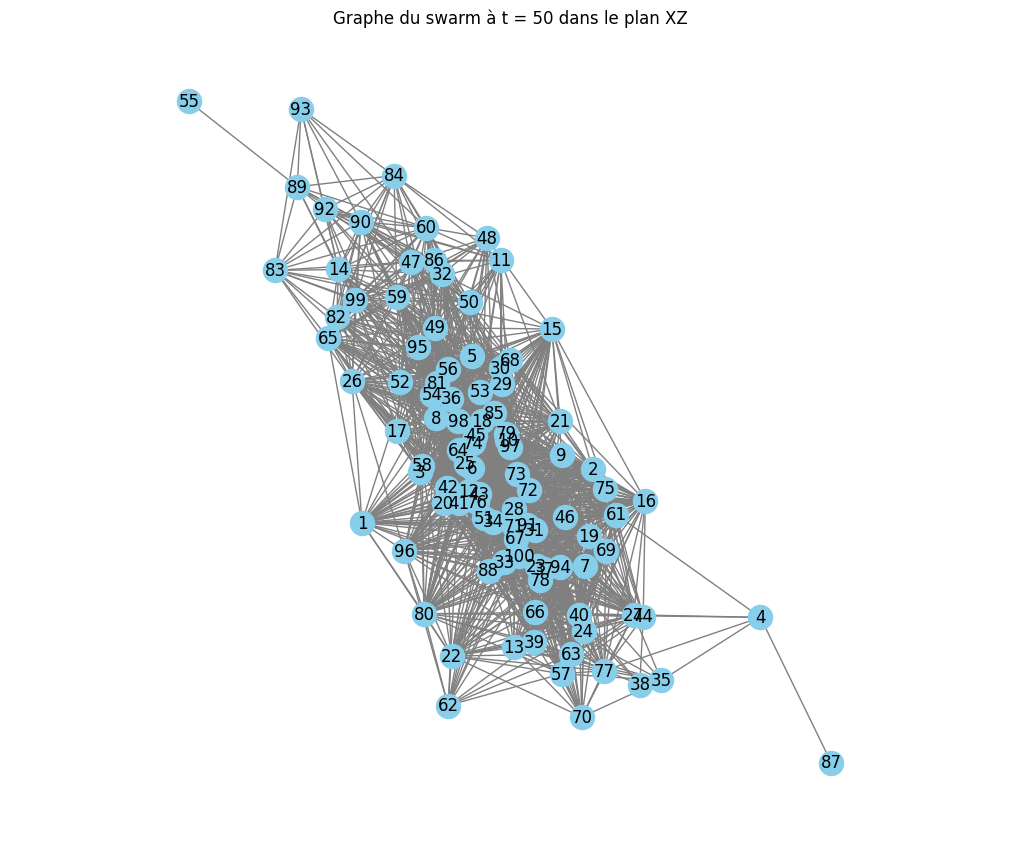

In [5]:
t = 50  # instant à visualiser
coords = dft.iloc[t]
nodes = []

for i in range(1, 101):
    x = coords[f'satx{i}']
    y = coords[f'saty{i}']
    z = coords[f'satz{i}']
    nodes.append(Node(id=i, x=x, y=y, z=z))
swarm = Swarm(connection_range=60000, nodes=nodes)
G = nx.Graph()

for node in nodes:
    G.add_node(node.id)

for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        dist = nodes[i].compute_dist(nodes[j])
        if dist <= 60000:
            G.add_edge(nodes[i].id, nodes[j].id)
# Choisir la projection : 'xy', 'xz' ou 'yz'
projection = 'xz'

pos_2d = {}
for node in nodes:
    if projection == 'xy':
        pos_2d[node.id] = (node.x, node.y)
    elif projection == 'xz':
        pos_2d[node.id] = (node.x, node.z)
    elif projection == 'yz':
        pos_2d[node.id] = (node.y, node.z)

plt.figure(figsize=(10, 8))
nx.draw(G, pos=pos_2d, with_labels=True, node_color='skyblue', edge_color='gray', node_size=300)
plt.title(f"Graphe du swarm à t = {t} dans le plan {projection.upper()}")
plt.axis('equal')
plt.grid(True)
plt.show()


In [6]:
def draw_swarm_graph(G, group_dict=None, title="Swarm Graph", ax=None):
    """
    Affiche un graphe avec coloration des groupes si group_dict est fourni.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    pos = nx.spring_layout(G, seed=42)

    if group_dict:
        groups = {}
        for node, group_id in group_dict.items():
            groups.setdefault(group_id, []).append(node)

        cmap = matplotlib.colormaps.get_cmap('tab10')
        for i, (group_id, nodes) in enumerate(groups.items()):
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                                   node_color= cmap(i % cmap.N)  , label=f"Groupe {group_id}", ax=ax)
    else:
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=600, ax=ax)

    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.5)
    ax.set_title(title)
    ax.axis('off')


In [7]:
def draw_swarm_graph_2D(G, nodes, group_dict=None, title="Swarm Graph 2D"):
    """
    Dessine un graphe 2D basé sur les coordonnées réelles X, Y des satellites.
    - G : le graphe NetworkX
    - nodes : liste de Node contenant les attributs x, y
    - group_dict : dictionnaire {node_id: group_id} si graph divisé
    """
    pos = {node.id: (node.x, node.y) for node in nodes}  # projection XY

    plt.figure(figsize=(10, 10))

    if group_dict:
        groups = {}
        for node_id, group_id in group_dict.items():
            groups.setdefault(group_id, []).append(node_id)
        cmap = matplotlib.colormaps.get_cmap('tab10')
        for i, (group_id, nodelist) in enumerate(groups.items()):
            nx.draw_networkx_nodes(G, pos, nodelist=nodelist, 
                                   node_color=[cmap(i % cmap.N)],
                                   label=f"Groupe {group_id}", node_size=300)
    else:
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=300)

    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
    plt.title(title)
    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.show()


### convert to swarm

In [ ]:
connection_range = 60000
portee1 =20000
portee2=40000
portee3= 60000
nanosat_count = 100
max_temps = 100  # pour test rapide
t_attack = 50 

#stocker les résultats pour chaque algo
resultats_FFD = []
resultats_MIRW = []
resultats_RND = []

# Liste des satellites encore actifs
satellites_actifs = set(range(1, nanosat_count + 1))

algos = ["FFD", "RND", "MIRW","KMeans"]

for algo in algos : 
    print("Traitement de l’algorithme :", algo)
    resultats=[]
    for t in tqdm(range(100), desc="Simulation en cours"):
        print(f"\n--- Temps t = {t} ---")
        coords = dft.iloc[t]
        nodes = []
        
        # Créer les objets Node
        for i in satellites_actifs:
            x = coords[f'satx{i}']
            y = coords[f'saty{i}']
            z = coords[f'satz{i}']
            nodes.append(Node(id=i, x=x, y=y, z=z))
    
        swarm = Swarm(connection_range=connection_range, nodes=nodes)
    
        # Créer un graphe pondéré
        G = nx.Graph()
        for node in nodes:
            G.add_node(node.id)
    
        # Ajouter les arêtes avec poids selon la distance
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                dist = nodes[i].compute_dist(nodes[j])
                if dist <= portee1:
                    weight = 1
                elif dist <= portee2:
                    weight = 2
                elif dist <= portee3:
                    weight = 3
                else:
                    continue  
                G.add_edge(nodes[i].id, nodes[j].id, weight=weight)
            # ----- Étape 1 : Métriques de base (graphe non divisé) -----
        metriques_avant = {
            "time": t,
            "algo": "none",
            "attack": "none",
            "efficacite":network_efficiency(G),
            "cout": routing_cost(G),
            "robustesse": flow_robustness(G),
            "redondance": path_redundancy(G),
            "disparite": path_disparity(G),
            "criticite": critical_nodes(G)
        }
        resultats.append(metriques_avant)
        print("  > Métriques avant division calculées.")
        #draw_swarm_graph(G, group_dict=None, title="Swarm Graph à t= 3", ax=None)
        #draw_swarm_graph_2D(G, nodes, group_dict=None, title=f"Graphe 2D avant division à t={t}")

        # ----- Étape 2 : Pour chaque algorithme de division -----
        if algo == "RND" :
            groupes = swarm.RND(n=5)
        elif algo == "MIRW" :
            groupes = swarm.MIRW(n=4)
        elif algo == "FFD" : 
            groupes = swarm.FFD(n=5)
        else: 
            groupes = swarm.kMeans(k=5) 
      
        # Construire group_dict
        group_dict = {}
        for group_id, sub_swarm in groupes.items():
            for n in sub_swarm.nodes:
                group_dict[n.id] = group_id
        #draw_swarm_graph(G, group_dict, title=f"Swarm Graph après division pour l'algorithme : {algo}", ax=None)
        #draw_swarm_graph_2D(G, nodes, group_dict=group_dict, title=f"Graphe 2D après division ({algo}) à t={t}")
        # ----- Métriques post-division -----
        metriques_div = {
            "time": t,
            "algo": algo,
            "attack": "none",
            "efficacite": network_efficiency(G, divided=True, group_dict=group_dict),
            "cout": routing_cost(G, divided=True, group_dict=group_dict),
            "robustesse": flow_robustness(G, divided=True, group_dict=group_dict),
            "redondance": path_redundancy(G, divided=True, group_dict=group_dict),
            "disparite": path_disparity(G, divided=True, group_dict=group_dict),
             "criticite": critical_nodes(G, divided=True, group_dict=group_dict)
        }
        
        resultats.append(metriques_div)
        print("  > Métriques après division calculées.")
        nb_noeuds_supprimes = 15
        # ----- Étape 3 : Appliquer les attaques -----
        t_attack = "random"
        G_copy = G.copy()
        
        if t == t_attack:
            attack_type = "random"
            if attack_type == "cible":
                BC = node_criticality(G_copy, divided=True, group_dict=group_dict)
            if attack_type == "random":
                nodes_to_remove = random.sample(list(G_copy.nodes), min(nb_noeuds_supprimes, len(G_copy)))
            else:  # attaque ciblée
                nodes_to_remove = sorted(BC, key=BC.get, reverse=True)[:nb_noeuds_supprimes]
    
            G_copy.remove_nodes_from(nodes_to_remove)
    
            # Retirer les satellites attaqués de la simulation
            satellites_actifs.difference_update(nodes_to_remove)
    
            # ----- Métriques post-attaque -----
        metriques_attaque = {
                "time": t,
                "algo": algo,
                "attack": attack_type,
                "efficacite": network_efficiency(G_copy, divided=True, group_dict=group_dict),
                "cout": routing_cost(G_copy, divided=True, group_dict=group_dict),
                "robustesse": flow_robustness(G_copy, divided=True, group_dict=group_dict),
                "redondance":path_redundancy(G_copy, divided=True, group_dict=group_dict),
                "disparite": path_disparity(G_copy, divided=True, group_dict=group_dict),
                "criticite": critical_nodes(G_copy, divided=True, group_dict=group_dict)
            }
        
        resultats.append(metriques_attaque)
        print("  > Métriques après attaque calculées.")
        if algo == "RND" :
            resultats_RND = resultats
        elif algo == "MIRW" :
            resultats_MIRW = resultats 
        elif algo == "FFD" :
            resultats_FFD = resultats 
        else:
            resultats_KMeans = resultats


Traitement de l’algorithme : FFD


Simulation en cours:   0%|                                                                     | 0/100 [00:00<?, ?it/s]


--- Temps t = 0 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   1%|▌                                                            | 1/100 [00:20<34:30, 20.91s/it]

  > Métriques après attaque calculées.

--- Temps t = 1 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   2%|█▏                                                           | 2/100 [00:40<32:30, 19.90s/it]

  > Métriques après attaque calculées.

--- Temps t = 2 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   3%|█▊                                                           | 3/100 [01:01<33:06, 20.47s/it]

  > Métriques après attaque calculées.

--- Temps t = 3 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   4%|██▍                                                          | 4/100 [01:26<35:41, 22.30s/it]

  > Métriques après attaque calculées.

--- Temps t = 4 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   5%|███                                                          | 5/100 [01:50<36:27, 23.03s/it]

  > Métriques après attaque calculées.

--- Temps t = 5 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   6%|███▋                                                         | 6/100 [02:20<39:54, 25.48s/it]

  > Métriques après attaque calculées.

--- Temps t = 6 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   7%|████▎                                                        | 7/100 [03:03<48:03, 31.01s/it]

  > Métriques après attaque calculées.

--- Temps t = 7 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   8%|████▉                                                        | 8/100 [03:34<47:24, 30.92s/it]

  > Métriques après attaque calculées.

--- Temps t = 8 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:   9%|█████▍                                                       | 9/100 [04:07<48:03, 31.68s/it]

  > Métriques après attaque calculées.

--- Temps t = 9 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  10%|██████                                                      | 10/100 [04:46<50:45, 33.84s/it]

  > Métriques après attaque calculées.

--- Temps t = 10 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  11%|██████▌                                                     | 11/100 [05:22<51:35, 34.78s/it]

  > Métriques après attaque calculées.

--- Temps t = 11 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  12%|███████▏                                                    | 12/100 [06:01<52:41, 35.93s/it]

  > Métriques après attaque calculées.

--- Temps t = 12 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  13%|███████▊                                                    | 13/100 [06:30<49:15, 33.97s/it]

  > Métriques après attaque calculées.

--- Temps t = 13 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  14%|████████▍                                                   | 14/100 [07:15<53:11, 37.11s/it]

  > Métriques après attaque calculées.

--- Temps t = 14 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  15%|█████████                                                   | 15/100 [07:59<55:36, 39.25s/it]

  > Métriques après attaque calculées.

--- Temps t = 15 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  16%|█████████▌                                                  | 16/100 [08:39<55:13, 39.45s/it]

  > Métriques après attaque calculées.

--- Temps t = 16 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  17%|██████████▏                                                 | 17/100 [09:12<51:54, 37.52s/it]

  > Métriques après attaque calculées.

--- Temps t = 17 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  18%|██████████▊                                                 | 18/100 [10:00<55:39, 40.72s/it]

  > Métriques après attaque calculées.

--- Temps t = 18 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  19%|███████████▍                                                | 19/100 [10:23<47:44, 35.37s/it]

  > Métriques après attaque calculées.

--- Temps t = 19 ---
  > Métriques avant division calculées.
  > Métriques après division calculées.


Simulation en cours:  20%|████████████                                                | 20/100 [10:44<41:15, 30.94s/it]

  > Métriques après attaque calculées.

--- Temps t = 20 ---


In [ ]:
# ========== Sauvegarde en CSV ==========
df_res1 = pd.DataFrame(resultats_FFD)
df_res1.to_csv("resultats_swarm_simulation_FFD.csv", index=False)

df_res2 = pd.DataFrame(resultats_RND)
df_res2.to_csv("resultats_swarm_simulation_RND.csv", index=False)

df_res3 = pd.DataFrame(resultats_MIRW)
df_res3.to_csv("resultats_swarm_simulation_MIRW.csv", index=False)

df_res4 = pd.DataFrame(resultats_KMeans)
df_res4.to_csv("resultats_swarm_simulation_KMeans.csv", index=False)


"""import os 
fichier1="resultats_swarm_simulation_FFD.csv"
if os.path.exists(fichier):
    print("existe")
else:
    print('existe pas')"""


### Analyse des Resultats 

In [ ]:

# Chargement du fichier CSV
df1 = pd.read_csv("resultats_swarm_simulation_FFD.csv")
df2 = pd.read_csv("resultats_swarm_simulation_RND.csv")
df3 = pd.read_csv("resultats_swarm_simulation_MIRW.csv")
df4 = pd.read_csv("resultats_swarm_simulation_KMeans.csv")


# Nettoyage et conversion
cols = ["time", "efficacite", "cout", "robustesse" ]
for df in [df1, df2, df3, df4]:
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Dictionnaire pour facilité l'accès
dfs = {
    "FFD": df1,
    "RND": df2,
    "MIRW": df3,
    "KMeans": df4
}

# Fonction pour tracer une métrique
def plot_metric(metric_name, ylabel, title):
    plt.figure(figsize=(5, 5))

    # Tracer la courbe non divisée (algo = none)
    
    df_non_div = df1[df1["algo"] == "none"]
    plt.plot(df_non_div["time"], df_non_div[metric_name], linestyle="--", label=f"Non divisé ")

    # Tracer la courbe divisée pour chaque algo
    for label, df in dfs.items():
        df_div = df[df["algo"] == label]
        plt.plot(df_div["time"], df_div[metric_name], label=f"Divisé - {label}")

    plt.xlabel("Temps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def boxplot_metric(metric_name, ylabel, title):
    plt.figure(figsize=(8, 6))
    
    data = []
    labels = []

    # Ajouter le cas "non divisé" une seule fois (depuis df1 par exemple)
    non_div_values = df1[df1["algo"] == "none"][metric_name].dropna()
    data.append(non_div_values)
    labels.append("Non divisé")

    # Ajouter les cas divisés pour chaque algo
    for label, df in dfs.items():
        div_values = df[df["algo"] == label][metric_name].dropna()
        data.append(div_values)
        labels.append(label)

    plt.boxplot(data, tick_labels=labels, patch_artist=True)
    plt.xticks(rotation=0)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# Tracer les trois métriques
plot_metric("robustesse", "Robustesse (connectivité)", "Évolution de la robustesse dans le temps")
plot_metric("cout", "Coût de routage", "Évolution du coût de routage dans le temps")
plot_metric("efficacite", "Efficacité du réseau", "Évolution de l'efficacité réseau dans le temps")





In [ ]:
# Tracer les boxplots
boxplot_metric("robustesse", "Robustesse (connectivité)", "Distribution de la robustesse par méthode")
boxplot_metric("cout", "Coût de routage", "Distribution du coût de routage par méthode")
boxplot_metric("efficacite", "Efficacité réseau", "Distribution de l'efficacité réseau par méthode")


In [ ]:
plot_metric("redondance", "Redondance (Ψₜ)", "Évolution de la redondance dans le temps")
plot_metric("disparite", "Disparité (Δₜ)", "Évolution de la disparité dans le temps")
plot_metric("criticite", "Criticité moyenne", "Évolution de la criticité dans le temps")


In [ ]:
boxplot_metric("redondance", "Redondance (Ψₜ)", "Distribution de la redondance par algorithme")
boxplot_metric("disparite", "Disparité (Δₜ)", "Distribution de la disparité par algorithme")
boxplot_metric("criticite", "Criticité moyenne", "Distribution de la criticité par algorithme")

### Evaluation du nombre de sommets par groupe en fonction du nombre de groupes par RMSE : 

In [ ]:
def rmse(data, ref=None):
    """
    This function calculates the Root Mean Square Error (RMSE) between the observed distribution and a reference value.

    Parameters:
    data (list or numpy array): A list or numpy array containing the observed data points.
    ref (float, optional): A reference value to compare the observed distribution with. Defaults to the mean of the observed data.

    Returns:
    float: The RMSE value, which represents the standard deviation of the differences between the observed data and the reference value.

    Example:
    >>> data = [1, 2, 3, 4, 5]
    >>> ref = 3
    >>> rmse(data, ref)
    0.8164965809277461
    """
    if ref is None:
        ref = np.mean(data)
    errors = [(e - ref) ** 2 for e in data]
    ratio = sum(errors) / len(data)
    return np.sqrt(ratio)
        

In [ ]:
# Construire les nodes à t = 55
t = 55
coords = dft.iloc[t]
nodes = []
for i in range(1, 101):
    x = coords[f"satx{i}"]
    y = coords[f"saty{i}"]
    z = coords[f"satz{i}"]
    nodes.append(Node(id=i, x=x, y=y, z=z))

# Paramètres
NB_NODES = 100
NB_GROUPS = np.arange(2, NB_NODES + 1)
NB_REPETITIONS = 10

swarm = Swarm(connection_range=60000, nodes=nodes)

rmse_rnd = []
rmse_mirw = []
rmse_ffd = []
rmse_kmeans = []

# Boucle d'évaluation
for nb in tqdm(NB_GROUPS, desc="Calcul des RMSE"):
    ref_ns = NB_NODES / nb

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.RND(n=nb, s=rep + 1)
        ns.extend([len(g.nodes) for g in groups.values()])
    rmse_rnd.append(rmse(ns, ref_ns))

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.MIRW(n=nb, s=rep + 1)
        ns.extend([len(g.nodes) for g in groups.values()])
    rmse_mirw.append(rmse(ns, ref_ns))

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.FFD(n=nb, s=rep + 1)
        ns.extend([len(g.nodes) for g in groups.values()])
    rmse_ffd.append(rmse(ns, ref_ns))

    ns = []
    for rep in range(NB_REPETITIONS):
        swarm.reset_groups()
        groups = swarm.kMeans(k=nb)
        ns.extend([len(g.nodes) for g in groups.values()])
    rmse_kmeans.append(rmse(ns, ref_ns))

# Tracer
plt.figure(figsize=(10, 6))
plt.plot(NB_GROUPS, rmse_rnd, '-r', label='RND')
plt.plot(NB_GROUPS, rmse_mirw, '--b', label='MIRW')
plt.plot(NB_GROUPS, rmse_ffd, '-.g', label='FFD')
plt.plot(NB_GROUPS, rmse_kmeans, ':', color='orange', label='KMeans')

plt.xlabel('Nombre de groupes')
plt.ylabel('RMSE (taille des groupes)')
plt.title("Équité de la répartition des nœuds entre groupes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
from collections import defaultdict
import numpy as np
import pandas as pd
import networkx as nx
import random
from tqdm import tqdm
from swarm_sim import Node, Swarm
from metrics import flow_robustness, network_efficiency, routing_cost, path_disparity, path_redundancy, critical_nodes

# Paramètres
connection_range = 60000
nb_suppressions = [5, 10, 15, 20, 25]
algos = ["FFD", "RND", "MIRW", "KMeans"]
NB_REP = 5
t = 50

# Charger les données
df = pd.read_csv("Traces.csv", header=None)
df.columns = [str(i+1) for i in range(df.shape[1])]
df["coords"] = [f"sat{coord}{i}" for i in range(1, 101) for coord in ['x', 'y', 'z']]
df = df.set_index("coords")
dft = df.transpose()

# Obtenir les nodes au temps t
coords = dft.iloc[t]
base_nodes = []
for i in range(1, 101):
    x = coords[f'satx{i}']
    y = coords[f'saty{i}']
    z = coords[f'satz{i}']
    base_nodes.append(Node(id=i, x=x, y=y, z=z))

# Résultats
resultats_attaques_random = defaultdict(list)

# Simulation
for algo in tqdm(algos, desc="Simulation des attaques"):
    for nb_suppr in nb_suppressions:
        robustesses = []

        for _ in range(NB_REP):
            nodes = [Node(id=n.id, x=n.x, y=n.y, z=n.z) for n in base_nodes]
            swarm = Swarm(connection_range=connection_range, nodes=nodes)

            if algo == "RND":
                groupes = swarm.RND(n=5)
            elif algo == "MIRW":
                groupes = swarm.MIRW(n=5)
            elif algo == "FFD":
                groupes = swarm.FFD(n=5)
            else:
                groupes = swarm.kMeans(k=5)

            group_dict = {}
            for group_id, sw in groupes.items():
                for n in sw.nodes:
                    group_dict[n.id] = group_id

            G = nx.Graph()
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    if nodes[i].compute_dist(nodes[j]) <= connection_range:
                        G.add_edge(nodes[i].id, nodes[j].id)

            G_copy = G.copy()
            nodes_to_remove = random.sample(list(G_copy.nodes), min(nb_suppr, len(G_copy)))
            G_copy.remove_nodes_from(nodes_to_remove)

            rob = flow_robustness(G_copy, divided=True, group_dict=group_dict)
            robustesses.append(rob)

        resultats_attaques_random[algo].append({
            "algo": algo,
            "nb_supprimes": nb_suppr,
            "robustesse_moyenne": np.mean(robustesses)
        })

# Convertir en DataFrame
df_resultats = pd.DataFrame()
for algo in algos:
    df_resultats = pd.concat([df_resultats, pd.DataFrame(resultats_attaques_random[algo])])

# Afficher
print(df_resultats)


Simulation des attaques: 100%|███████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]

     algo  nb_supprimes  robustesse_moyenne
0     FFD             5            0.870444
1     FFD            10            0.888609
2     FFD            15            0.902415
3     FFD            20            0.850864
4     FFD            25            0.839947
0     RND             5            0.872706
1     RND            10            0.868118
2     RND            15            0.818966
3     RND            20            0.802269
4     RND            25            0.787823
0    MIRW             5            0.894159
1    MIRW            10            0.888609
2    MIRW            15            0.902415
3    MIRW            20            0.850864
4    MIRW            25            0.839947
0  KMeans             5            0.995978
1  KMeans            10            1.000000
2  KMeans            15            1.000000
3  KMeans            20            0.993384
4  KMeans            25            0.999403


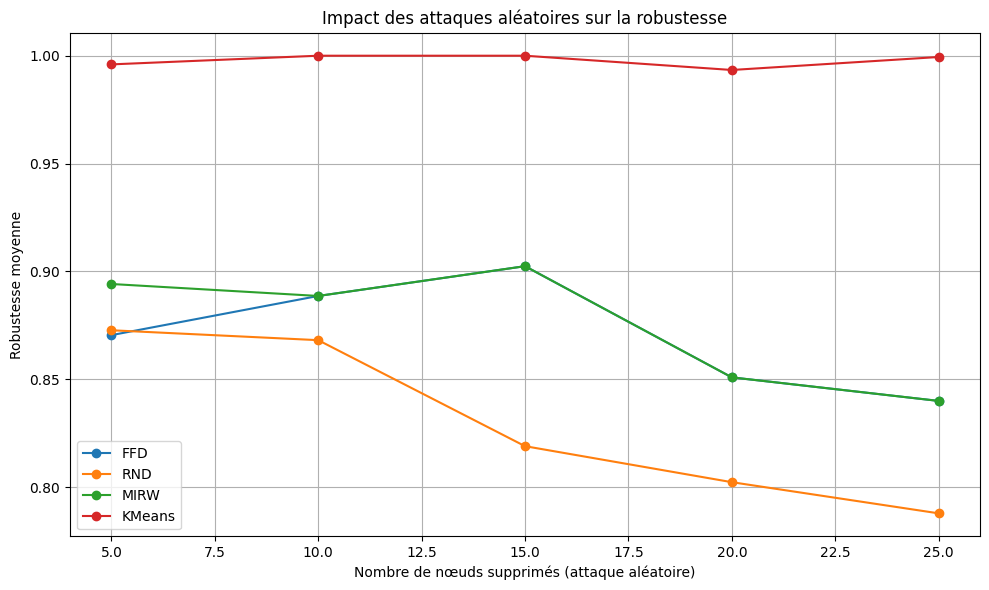

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for algo in algos:
    subset = df_resultats[df_resultats['algo'] == algo]
    plt.plot(subset['nb_supprimes'], subset['robustesse_moyenne'], marker='o', label=algo)

plt.xlabel("Nombre de nœuds supprimés (attaque aléatoire)")
plt.ylabel("Robustesse moyenne")
plt.title("Impact des attaques aléatoires sur la robustesse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
